# MeteOsona Data Scrapping

In [334]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import datetime
import logging
import json
import matplotlib.pyplot as plt

## Meteosona metadata scrapping

In [5]:
url = "https://www.meteosona.com/"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

script_tag = soup.find('script', text=lambda text: text and 'var estacions =' in text)

if script_tag:
    estacions_variable = script_tag.text
    start_index = estacions_variable.find('var estacions = ') + len('var estacions = ')
    end_index = estacions_variable.find(';', start_index)
    estacions_data = estacions_variable[start_index:end_index]
    estacions_dict = json.loads(estacions_data, parse_constant=lambda x: None)
    
else:
    print("Unable to locate the 'estacions' variable on the website. :(")


/var/folders/76/bszhb_2s2k96xxhr9gsw39w80000gn/T/ipykernel_11935/1240470503.py:6: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find('script', text=lambda text: text and 'var estacions =' in text)


## Meteosona station scrapping

In [179]:
#create construction dataframe and results dataframe
column_names = ['day', 
                'daily precipitation (l/m2)', 
                'temperature max (C)','temperature min (C)', 'temperature mean (C)',
                'humidity max (%)', 'humidity min (%)', 'humidity mean (%)',
                'wind max (km/h)', 'wind dir', 
                'pressure max (hPa)', 'pressure min (hPa)', 'pressure mean (hPa)',
                'solar irradiation (J/m2)',
                'date','latitude', 'longitude', 'altitude (m)', 'estacio' ]
df_res = pd.DataFrame(columns=column_names)
for estacio_k in estacions_dict.keys():
    estacio=estacions_dict[estacio_k]
    logging.warning(f'Loading estació {estacio["nom"]}...')
    found_estacio=False
    for year in range(2023, 1900, -1):
        found_year=False
        months = [i+1 for i in range(13)]
        months = months[:6] if year==2023 else months
        for month in months:
            url = f'https://www.meteosona.com/estacio/{estacio["nom_url"]}/{str(month)}/{str(year)}/#sectEstacionsResum'
            # Send a GET request to the website
            response = requests.get(url)
            if response.ok:
                soup = BeautifulSoup(response.content, 'html.parser')

                table = soup.find('table', {'id': 'taula_estacio'})

                data = []
                for row in table.find_all('tr'):
                    row_data = []

                    #add html table data
                    for cell in row.find_all('td'):
                        row_data.append(cell.text.strip())
                    if len(row_data)==14:
                        #add date
                        row_data.append(datetime.date(year, month, int(row_data[0])))
                        #add lat, lon & altitude
                        row_data.append(estacio['latitud'])
                        row_data.append(estacio['longitud'])
                        row_data.append(estacio['altitud'])
                        row_data.append(estacio['nom'])
                        data.append(row_data)
                        if not found_estacio:
                            logging.warning('Found data !')
                            found_estacio=True
                        if not found_year:
                            found_year=True

                if len(data)>0:
                    new_rows_df = pd.DataFrame(data, columns=df_res.columns)

                    # Append the new row to the existing dataframe
                    df_res = pd.concat([df_res, new_rows_df], ignore_index=True)
            #if no data found for given year, don't check the next one.
        if not found_year:
            if found_estacio:
                logging.warning(f'last data for {estacio["nom"]} is {year+1}')
            break
    if not found_estacio:
        logging.warning(f'No data found for {estacio["nom"]}')

df_res.to_csv('data/meteosona/all_estacions.csv')

### Sanity checks

In [81]:
import pandas as pd
import datetime
import json
import matplotlib.pyplot as plt
df_res = pd.read_csv('data/meteosona/all_estacions.csv')

In [82]:
for estacio in df_res['estacio'].unique():
    df_test =df_res[df_res['estacio']==estacio].reset_index(drop=True)
    alt=df_test['altitude (m)'].iloc[0]
    lat=df_test['latitude'].iloc[0]
    lon=df_test['longitude'].iloc[0]
    for i in range(len(df_test)):
        assert alt == df_test['altitude (m)'].iloc[i], f'nop: {df_test["altitude (m)"].iloc[i]}'        
        assert lat == df_test['latitude'].iloc[i], f'nop: {df_test["latitude"].iloc[i]}'
        assert lon == df_test['longitude'].iloc[i], f'nop: {df_test["longitude"].iloc[i]}'

### Type Casting

In [83]:
df_res['date'] = pd.to_datetime(df_res['date'])

In [84]:
cols_to_float_cast=[
                'daily precipitation (l/m2)', 
                'temperature max (C)','temperature min (C)', 'temperature mean (C)',
                'humidity max (%)', 'humidity min (%)', 'humidity mean (%)',
                'wind max (km/h)', 
                'pressure max (hPa)', 'pressure min (hPa)', 'pressure mean (hPa)',
                'solar irradiation (J/m2)',
                'latitude', 'longitude', 'altitude (m)']
for column in cols_to_float_cast:
    df_res[column] = pd.to_numeric(df_res[column], errors='coerce').astype(float)


# Quick Data Analysis

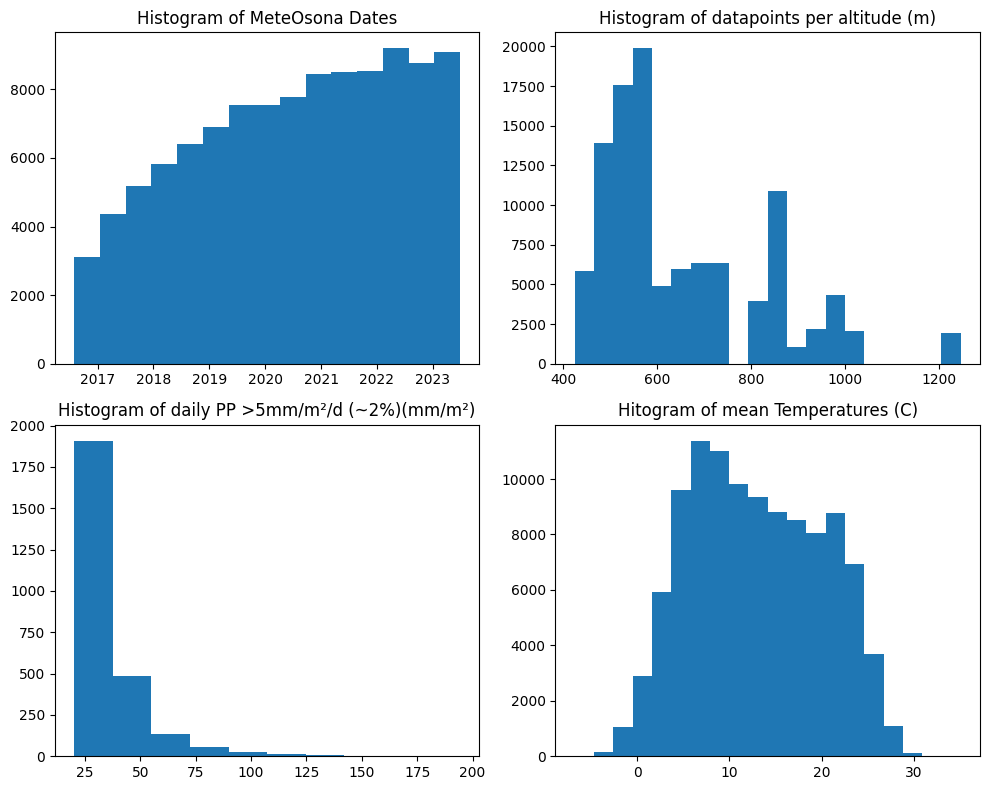

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].hist(df_res['date'], bins=15)
axs[0, 0].set_title('Histogram of MeteOsona Dates')

axs[0, 1].hist(df_res['altitude (m)'], bins=20)
axs[0, 1].set_title('Histogram of datapoints per altitude (m)')

axs[1, 0].hist(df_res[df_res['daily precipitation (l/m2)']>20]['daily precipitation (l/m2)'], bins=10)
axs[1, 0].set_title(f'Histogram of daily PP >5mm/m²/d (~{int(100*len(df_res[df_res["daily precipitation (l/m2)"]>20])/len(df_res))}%)(mm/m²)')

axs[1, 1].hist(df_res['temperature mean (C)'], bins=20)
axs[1, 1].set_title('Hitogram of mean Temperatures (C)')

fig.tight_layout()
plt.show()

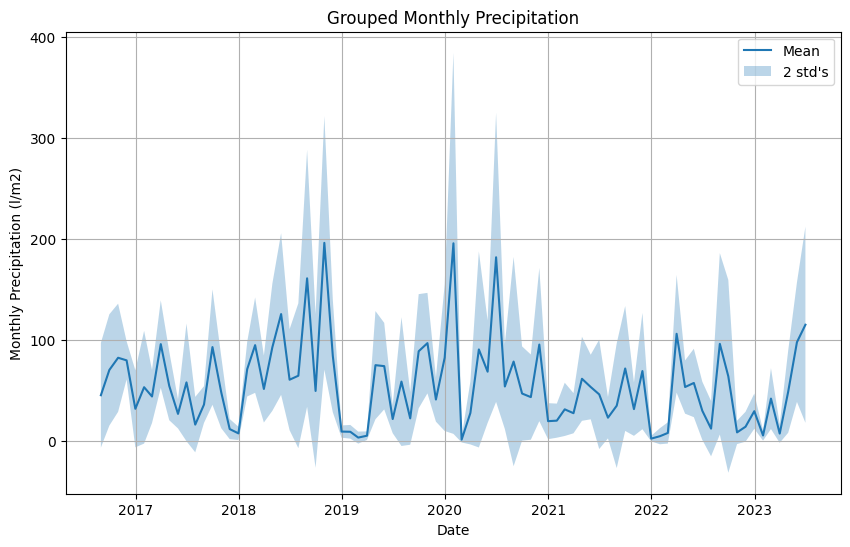

In [86]:
import numpy as np
df = df_res.set_index('date', inplace=False)
monthly_precipitation_bystation = df.groupby('estacio')['daily precipitation (l/m2)'].resample('M').sum()
monthly_precipitation = pd.DataFrame(monthly_precipitation_bystation).droplevel(level=0).resample('M').mean()
monthly_precipitation_std = pd.DataFrame(monthly_precipitation_bystation).droplevel(level=0).resample('M').std()

mean_values = monthly_precipitation['daily precipitation (l/m2)']
std_values = monthly_precipitation_std['daily precipitation (l/m2)']*2

# Plotting the mean and standard deviation as an envelope
plt.figure(figsize=(10, 6))
plt.plot(monthly_precipitation.index, mean_values, label='Mean')
plt.fill_between(monthly_precipitation.index, 
                 mean_values - std_values, 
                 mean_values + std_values,
                 alpha=0.3, label="2 std's")
plt.xlabel('Date')
plt.ylabel('Monthly Precipitation (l/m2)')
plt.title('Grouped Monthly Precipitation')
plt.legend()
plt.grid(True)
plt.show()

# Correlations

In [87]:
monthly_precipitation = pd.DataFrame(monthly_precipitation_bystation).droplevel(level=0).resample('M').mean()

In [88]:
df_res['season'] = df_res['date'].apply(lambda d: 'Winter' if d.month >9 or d.month<4 else 'Summer')
df_res['year'] = df_res['date'].apply(lambda d: d.year)

In [17]:
a = df_res[['temperature mean (C)', 'altitude (m)','estacio', 'season','year']].groupby(['altitude (m)','estacio', 'season','year']).mean().reset_index()
b = df_res[['daily precipitation (l/m2)', 'altitude (m)','estacio', 'season','year']].groupby(['altitude (m)','estacio', 'season','year']).mean().reset_index()

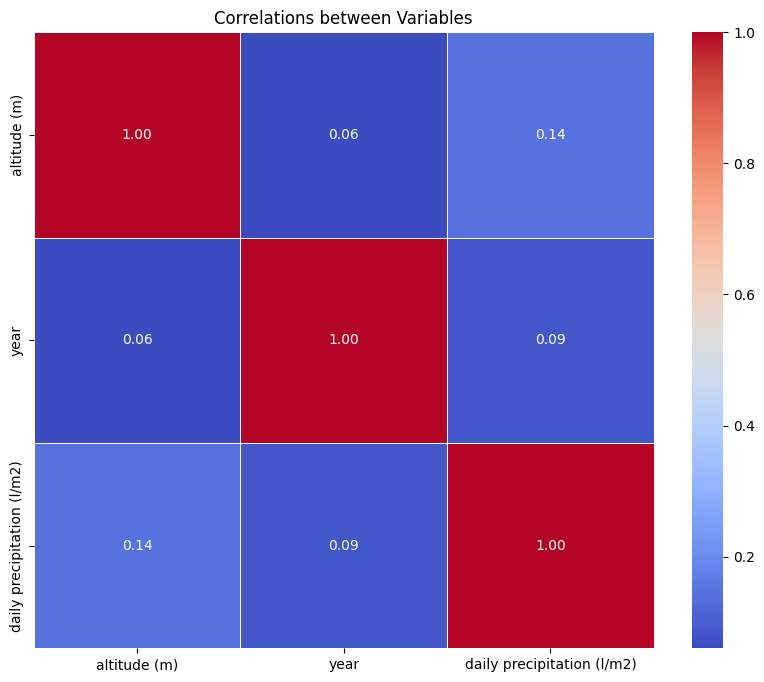

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called df
correlation_matrix = b[b['season']=='Summer'].drop(['season', 'estacio'], axis=1).corr()

# Plot correlations between variables
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlations between Variables')
plt.show()


## Altitude's influence on Temperature

In [95]:
df_res[df_res['altitude (m)'] == 425]['date']

76342   2023-01-01
76343   2023-01-08
76344   2023-01-09
76345   2023-01-17
76346   2023-01-18
           ...    
78802   2016-12-27
78803   2016-12-28
78804   2016-12-29
78805   2016-12-30
78806   2016-12-31
Name: date, Length: 2465, dtype: datetime64[ns]

In [126]:
t = df_res[df_res['altitude (m)'] == 425].groupby('date')['temperature mean (C)'].mean().reset_index()

In [129]:
t[t['date'].dt.year>=2023].index

TypeError: 'Index' object is not callable

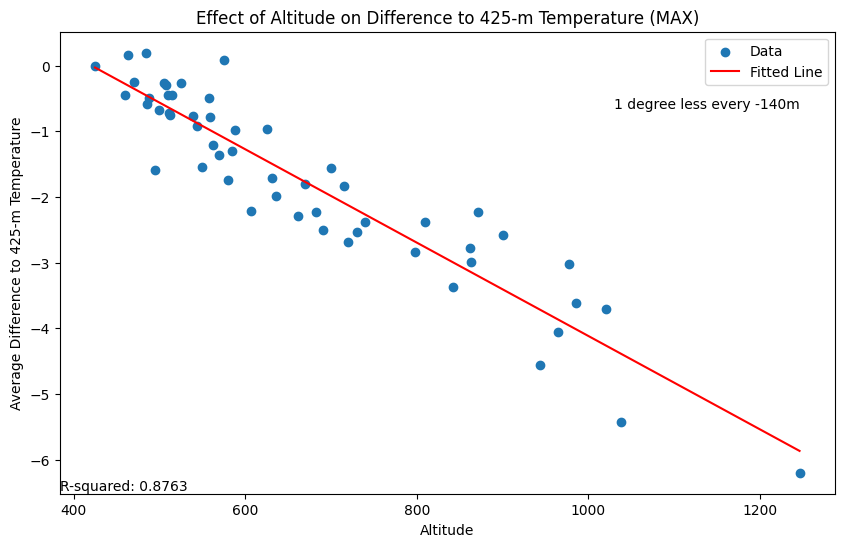

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

temps_425m = df_res[df_res['altitude (m)']==425].set_index('date')

df_res['425m'] = df_res['date'].apply(lambda d: temps_425m['temperature max (C)'].loc[d] if d in temps_425m.index else np.nan)
# Step 3: Calculate Difference to Mean Temperature
df_res['difference_to_mean'] = df_res['temperature max (C)'] - df_res['425m']

# Step 4: Analyze the Effect of Altitude

# Group by altitude levels and calculate the average difference to mean temperature
average_difference = df_res.groupby('altitude (m)')['difference_to_mean'].mean().reset_index()

# Step 5: Visualize the Effect of Altitude
# Perform linear regression
X = average_difference[['altitude (m)']]
y = average_difference[['difference_to_mean']]
reg = LinearRegression()
reg.fit(X, y)

# Predict the values using the linear model
y_pred = reg.predict(X)

# Calculate R-squared value
r2 = r2_score(y, y_pred)

# Step 6: Visualize the Effect of Altitude with the Fitted Line

# Plotting the relationship between altitude and average difference to mean temperature with the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(average_difference['altitude (m)'], average_difference['difference_to_mean'], label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('Altitude')
plt.ylabel('Average Difference to 425-m Temperature')
plt.title('Effect of Altitude on Difference to 425-m Temperature (MAX)')
plt.text(plt.xlim()[0], plt.ylim()[0], f'R-squared: {r2:.4f}', verticalalignment='bottom', horizontalalignment='left')
plt.text(0.8*plt.xlim()[1], 0.1*plt.ylim()[0], f'1 degree less every {int(1/ reg.coef_[0][0])}m')
plt.legend()
plt.show()

In [166]:
df_test

,year,estacio,daily precipitation (l/m2),altitude (m),mean_year_pluvio,mean_year_pluvio_estacio,difference_to_mean
0,2016,Calldetenes,257.6,488.0,100967.690476,94024.0,-6943.690476
1,2016,Espinelves,343.4,730.0,100967.690476,125341.0,24373.309524
2,2016,"Gurb ""El Serrat""",290.4,525.0,100967.690476,105996.0,5028.309524
3,2016,Gurb Escoles,118.0,484.0,100967.690476,43070.0,-57897.690476
4,2016,L'Esquirol,288.8,691.0,100967.690476,105412.0,4444.309524
...,...,...,...,...,...,...,...
356,2023,Tona IES,270.4,607.0,116054.357143,98696.0,-17358.357143
357,2023,Torelló,329.6,511.0,116054.357143,120304.0,4249.642857
358,2023,Vic,445.2,500.0,116054.357143,162498.0,46443.642857
359,2023,Vidrà,354.4,985.0,116054.357143,129356.0,13301.642857


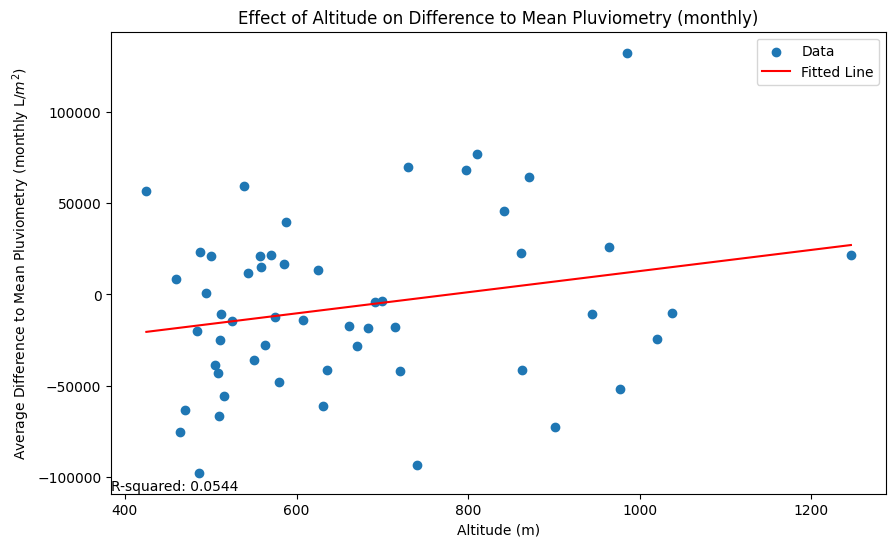

In [165]:
df_res['month'] = df_res['date'].dt.month
df_res['year'] = df_res['date'].dt.year

# Step 3: Calculate Difference to Mean Pluviometry
df_test = df_res.groupby(['year', 'estacio'])[['daily precipitation (l/m2)', 'altitude (m)']].agg(
    {'daily precipitation (l/m2)': 'sum', 'altitude (m)': 'mean' }
).reset_index()

df_test['mean_year_pluvio'] = df_test.groupby(['year'])['daily precipitation (l/m2)'].transform('mean') * 365
df_test['mean_year_pluvio_estacio'] = df_test.groupby(['year', 'altitude (m)'])['daily precipitation (l/m2)'].transform('mean') * 365

df_test['difference_to_mean'] = df_test['mean_year_pluvio_estacio'] - df_test['mean_year_pluvio']

# Step 4: Analyze the Effect of Altitude

# Group by altitude levels and calculate the average difference to mean pluviometry
average_difference = df_test.groupby('altitude (m)')['difference_to_mean'].mean().reset_index()

# Step 5: Fit a Line and Calculate R-squared

# Perform linear regression
X = average_difference[['altitude (m)']]
y = average_difference['difference_to_mean']
reg = LinearRegression()
reg.fit(X, y)

# Predict the values using the linear model
y_pred = reg.predict(X)

# Calculate R-squared value
r2 = r2_score(y, y_pred)

# Step 6: Visualize the Effect of Altitude with the Fitted Line

# Plotting the relationship between altitude and average difference to mean pluviometry with the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(average_difference['altitude (m)'], average_difference['difference_to_mean'], label='Data')
plt.plot(X, y_pred, color='red', label='Fitted Line')
plt.xlabel('Altitude (m)')
plt.ylabel('Average Difference to Mean Pluviometry (monthly L/$m^2$)')
plt.title('Effect of Altitude on Difference to Mean Pluviometry (monthly)')
plt.legend()

# Display R-squared value on the plot
plt.text(plt.xlim()[0], plt.ylim()[0], f'R-squared: {r2:.4f}', verticalalignment='bottom', horizontalalignment='left')

plt.show()